
# **The principle of operation of gradient boosting for regression**

The algorithm is constructed as follows:
- 1) the initial prediction is assigned the average value of y_train for all samples;
- 2) the residuals of the model are calculated based on the anti-gradient of the loss function;
- 3) the regression tree is trained on X_train and residuals, then a prediction is made on X_train;
- 4) the resulting prediction is added to the original one and steps 2-4 are repeated for each tree;
- 5) after training all models, the initial prediction from step 1 is created again;
- 6) next, predictions are made for X_test on trained trees and added to the initial one;
- 7) the amount received will be the final prediction.

**Formulas for calculations**

$L(y_i, F(x_i)) = \frac{1}{2} (y_i - F(x_i))^2 \ - \ $ loss function

$r_{ik} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_
{F(x) = F_{m-1}(x)} = y_{i} - F_{m-1}(x_i) \ - \ $ residuals

# **The principle of operation of gradient boosting for classification**
In the case of classification things are a little more complicated: one-hot encoding must be applied to each unique class and translated into probabilities using a softmax function and a $\gamma$ coefficient must be added to tree predictions which regulates the degree of contribution of each new tree to the overall model to reduce overfitting. Also the quality of gradient boosting predictions can be significantly improved by applying the K-class LogitBoost concept: weights are calculated for each tree and only then the residuals are based on them.

The algorithm is constructed as follows:
- 1) one-hot encoding is used for y_train and the initial prediction is assigned values of 0 for each class;
- 2) predictions are converted into probabilities using the softmax function;
- 3) the residuals of the model are calculated based on the anti-gradient of the loss function and probabilities (as well as the weight in the case of LogitBoost);
- 4) the regression tree is trained on X_train and residuals (and in the case of LogitBoost, weights are also assigned), then a prediction is made on X_train;
- 5) for each leaf in the tree the coefficients $\gamma$ are calculated based on the residuals taken from the positions of observations that fell into a certain leaf node;
- 6) the obtained predictions for each class and the sum of the coefficients $\gamma$ are added to the initial ones;
- 7) steps 2-6 are repeated for each tree in each class;
- 8) after training all models an initial prediction is created from step 1;
- 9) next, predictions are made for X_test on trained trees for each class and added to the initial ones;
- 10) classes with the maximum amount will be the final prediction.

**Formulas for calculations**

$L(\{y_k, F_k(x)\}_{1}^{K}) = -\sum\limits_{k=1}^{K} y_k \ log \ p_k(x) \ - \ $ loss function

$p_k(x) = softmax(F_k(x)) = \frac{e^{F_k(x)}}{\sum\limits_{l=1}^{K} e^{F_l(x)}} \ - \ $ probability of each class

$r_{ik} = -\left[\frac{\partial L(\{y_{il}, F_l(x_i)\}_{l=1}^{K})}{\partial F_k(x_i)}\right]_
{\{F_l(x) = F_{l,m-1}(x)\}_{1}^{K}} = y_{ik} - p_{k,m-1}(x_i) \ - \ $ residuals

$\gamma_{jkm} = \frac{K-1}{K} \frac{\sum_{x_i \in R_{jkm}} r_{ik}}
{\sum_{x_i \in R_{jkm}} |r_{ik}| (1 - |r_{ik}|)}$

$w_k(x_i) = p_k(x_i) (1 - p_k(x_i)) \ - \ $ weigts for K-class LogitBoost

$r_{ik} = \frac{K-1}{K} \frac{y_{ik} - p_k(x_i)}{w_k(x_i)} \ - \ $ residuals for K-class LogitBoost

### **Python implementation from scratch**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from mlxtend.plotting import plot_decision_regions

In [2]:
class GBMClassifier:
    def __init__(self, logitboost=False, learning_rate=0.1, n_estimators=100,
                 max_depth=3, random_state=0):
        self.logitboost = logitboost
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state

    def _softmax(self, predictions):
        exp = np.exp(predictions)

        return exp / np.sum(exp, axis=1, keepdims=True)

    def _compute_gammas(self, residuals, leaf_indexes, eps=1e-4):
        gammas = []

        for j in np.unique(leaf_indexes):
            x_i = np.where(leaf_indexes == j)
            numerator = np.sum(residuals[x_i])
            norm_residuals_xi = np.linalg.norm(residuals[x_i]) + eps
            denominator = np.sum(norm_residuals_xi * (1 - norm_residuals_xi))
            gamma = (self.K - 1) / self.K * numerator / denominator
            gammas.append(gamma)

        return gammas

    def fit(self, X, y):
        self.K = len(np.unique(y))
        self.trees = {k: [] for k in range(self.K)}
        one_hot_y = pd.get_dummies(y).to_numpy()   # one-hot encoding
        predictions = np.zeros(one_hot_y.shape)

        for _ in range(self.n_estimators):
            probabilities = self._softmax(predictions)

            for k in range(self.K):
                if self.logitboost:   # based on K-class LogitBoost
                    numerator = (one_hot_y.T[k] - probabilities.T[k])
                    denominator = probabilities.T[k] * (1 - probabilities.T[k])
                    residuals = (self.K - 1) / self.K * numerator / denominator
                    weights = denominator
                else:
                    residuals = one_hot_y.T[k] - probabilities.T[k]
                    weights = None

                tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth,
                                             random_state=self.random_state)
                tree.fit(X, residuals, sample_weight=weights)
                self.trees[k].append(tree)

                leaf_indexes = tree.apply(X)
                gammas = [] if self.logitboost else self._compute_gammas(residuals, leaf_indexes)
                predictions.T[k] += self.learning_rate * tree.predict(X) + np.sum(gammas)

    def predict(self, samples):
        predictions = np.zeros((len(samples), self.K))

        for i in range(self.n_estimators):
            for k in range(self.K):
                predictions.T[k] += self.learning_rate * self.trees[k][i].predict(samples)

        return np.argmax(predictions, axis=1)

In [3]:
class GBMRegressor:
    def __init__(self, learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        self.initial_leaf = y.mean()
        predictions = np.zeros(len(y)) + self.initial_leaf

        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth,
                                         random_state=self.random_state)
            tree.fit(X, residuals)
            predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

    def predict(self, samples):
        predictions = np.zeros(len(samples)) + self.initial_leaf

        for i in range(self.n_estimators):
            predictions += self.learning_rate * self.trees[i].predict(samples)

        return predictions

In [4]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Glass Classification](https://www.kaggle.com/datasets/uciml/glass) dataset will be used to train models, where it is necessary to correctly determine the type of glass by its characteristics. In the case of regression, Diabetes dataset from scikit-learn is used.

**The data below will be used in the examples for all modifications of gradient boosting**.

In [5]:
glass_df = pd.read_csv('/content/glass.csv')

In [9]:
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [6]:
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]

In [7]:
y1 = pd.Series(LabelEncoder().fit_transform(y1))

In [8]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)

In [10]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)

In [11]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)

In [12]:
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

# **Model training and evaluation of the obtained results**  
In the case of classification the manual implementation differs slightly in terms of accuracy from scikit-learn. This is due to the fact that the latter uses a more sophisticated approach for predicting and calculating residuals, but the essence remains the same and in most cases it works about the same as the manual implementation, especially in comparison with the LogitBoost modification.

In the case of regression the error in manual implementation is even slightly lower than in scikit-learn — the differences are insignificant.

It is also worth noting that scikit-learn has a special version of gradient boosting — HistGradientBoosting based on LightGBM, designed to work with large datasets which performs much faster and more often better than classic gradient boosting.

The results are shown below.

**GBMClassifier**

In [13]:
gbc = GBMClassifier(random_state=0)
gbc.fit(X1_train, y1_train)

In [14]:
gbc_pred_res = gbc.predict(X1_test)

In [15]:
gbc_accuracy = accuracy_score(y1_test, gbc_pred_res)

In [16]:
print(f'gbc accuracy: {gbc_accuracy}')
print(gbc_pred_res)

gbc accuracy: 0.6111111111111112
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 1 1 5 0 5 5 1 0 5 0 1 0 0 4 1 0 0 0 0
 0 0 5 1 4 1 0 0 1 0 1 0 1 0 3 5 0]


**GBMClassifier with LogitBoost concept**

In [17]:
logit_bc = GBMClassifier(logitboost=True, random_state=0)
logit_bc.fit(X1_train, y1_train)

In [18]:
logit_bc_pred_res = logit_bc.predict(X1_test)

In [19]:
logit_bc_accuracy = accuracy_score(y1_test, logit_bc_pred_res)

In [20]:
print(f'logit_gbc accuracy: {logit_bc_accuracy}')
print(logit_bc_pred_res)

logit_gbc accuracy: 0.6666666666666666
[5 0 1 4 1 1 0 1 1 1 1 0 0 1 1 5 2 1 1 0 3 0 5 1 2 0 5 0 0 1 0 0 1 0 0 0 0
 2 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]


**GradientBoostingClassifier (scikit-learn)**

In [21]:
sk_gbc = GradientBoostingClassifier(random_state=0)
sk_gbc.fit(X1_train, y1_train)

GradientBoostingClassifier(random_state=0)

In [22]:
sk_gbc_pred_res = sk_gbc.predict(X1_test)

In [23]:
sk_gbc_accuracy = accuracy_score(y1_test, sk_gbc_pred_res)

In [24]:
print(f'sk_gbc accuracy: {sk_gbc_accuracy}')
print(sk_gbc_pred_res)

sk_gbc accuracy: 0.6666666666666666
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 2 1 2 0 1 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 1 1 1 0 1 1 0 1 0 1 0 1 5 0]


In [25]:
feature_indexes = [1, 3]

/usr/local/lib/python3.11/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


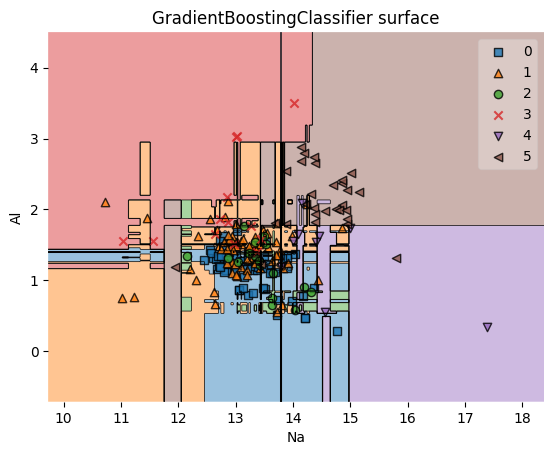

In [26]:
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_gbc, feature_indexes, 'GradientBoostingClassifier surface')

**HistGradientBoostingClassifier (scikit-learn)**

In [28]:
sk_hist_gbc = HistGradientBoostingClassifier(random_state=0)
sk_hist_gbc.fit(X1_train, y1_train)

HistGradientBoostingClassifier(random_state=0)

In [29]:
sk_hist_gbc_pred_res = sk_hist_gbc.predict(X1_test)

In [30]:
sk_hist_gbc_accuracy = accuracy_score(y1_test, sk_hist_gbc_pred_res)

In [31]:
print(f'sk_hist_gbc accuracy: {sk_hist_gbc_accuracy}')
print(sk_hist_gbc_pred_res)

sk_hist_gbc accuracy: 0.7407407407407407
[5 0 1 4 1 1 0 1 1 1 0 1 0 1 1 5 2 1 0 2 3 0 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 2 0 5 1 4 1 0 0 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.11/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


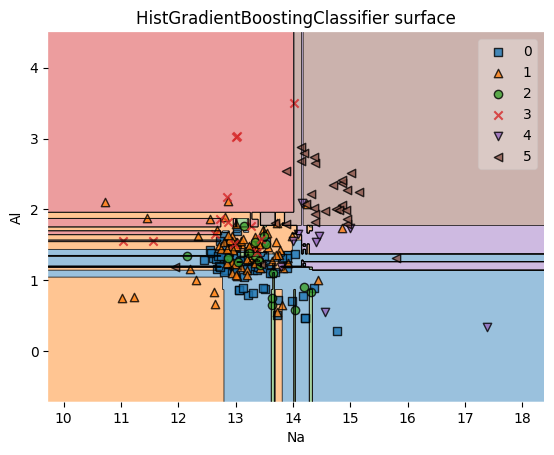

In [32]:
feature_indexes = [1, 3]

decision_boundary_plot(X1, y1, X1_train, y1_train, sk_hist_gbc, feature_indexes, 'HistGradientBoostingClassifier surface')

**GBMRegressor**

In [33]:
gbr = GBMRegressor(random_state=0)
gbr.fit(X2_train, y2_train)

In [34]:
gbr_pred_res = gbr.predict(X2_test)
mape = mean_absolute_percentage_error(y2_test, gbr_pred_res)

In [35]:
print(f'gbr mape: {mape}')
print(gbr_pred_res)

gbr mape: 0.399913339601999
[255.26058697 236.87383554 189.22369747 111.4291292  195.31958776
 249.2293251   97.46956406 205.91110801 133.47952304 240.88679883
 187.19018483 171.09963906 132.63933991  86.28964353 286.56077589
 105.78347251 161.94686043  72.58069452 105.92470096 236.52718059
 178.31146418 127.93036968 164.16563703 147.68681371 229.72747212
 194.16656023 142.44300193  68.79177464 237.21638657 163.36730299
 228.0338107   85.82843049 122.42781509 153.99332065 133.44848601
 159.00754731 151.98981608 147.1238119   88.56372077 200.84785209
 111.32129613 157.60108633 137.94395538 173.39402287 176.29284757
  62.85019316 109.646804   124.14982054  83.45697583 266.40618239
 141.2307366   42.05033124 163.57898214 149.92213387 230.37326368
 226.98842404 176.95426024 128.73302071  94.7641018  180.13853236
 242.31821245 147.52903035 130.45931832  97.32617479 246.70709949
 155.26338705  88.36785447 243.39330218 215.93042351  57.89243255
  87.76236479 138.21222825 101.23449416 140.8052

**GradientBoostingRegressor (scikit-learn)**

In [40]:
sk_gbr = GradientBoostingRegressor(random_state=0)
sk_gbr.fit(X2_train, y2_train)
sk_gbr_pred_res = sk_gbr.predict(X2_test)
sk_mape = mean_absolute_percentage_error(y2_test, sk_gbr_pred_res)
print(f'sk_gbr mape: {sk_mape}')
print(sk_gbr_pred_res)


sk_gbr mape: 0.4010647096251489
[255.26058697 236.87383554 189.22369747 111.4291292  195.31958776
 249.2293251   97.46956406 205.91110801 133.47952304 240.88679883
 187.19018483 171.09963906 132.63933991  86.28964353 286.56077589
 105.78347251 161.94686043  72.58069452 105.92470096 236.52718059
 182.08417504 127.93036968 164.16563703 147.68681371 229.72747212
 194.16656023 142.44300193  68.79177464 237.21638657 163.36730299
 223.14955275  85.82843049 122.42781509 153.99332065 133.44848601
 159.00754731 151.98981608 147.1238119   88.56372077 200.84785209
 117.71059889 157.60108633 137.94395538 173.39402287 176.29284757
  62.85019316 109.646804   124.14982054  83.45697583 266.40618239
 141.2307366   42.05033124 163.57898214 149.92213387 230.37326368
 226.98842404 176.95426024 128.73302071  94.7641018  180.13853236
 242.31821245 147.52903035 131.71442058  97.32617479 246.70709949
 155.26338705  88.36785447 243.39330218 215.93042351  54.04270734
  87.76236479 138.21222825 101.23449416 140.

**HistGradientBoostingRegressor (scikit-learn)**

In [37]:
sk_hist_gbr = HistGradientBoostingRegressor(random_state=0)
sk_hist_gbr.fit(X2_train, y2_train)
sk_hist_gbr_pred_res = sk_hist_gbr.predict(X2_test)
sk_hist_mape = mean_absolute_percentage_error(y2_test, sk_hist_gbr_pred_res)
print(f'sk_hist_gbr mape: {sk_hist_mape}')
print(sk_hist_gbr_pred_res)

sk_hist_gbr mape: 0.39301688868165796
[264.59007545 243.59190524 180.62442773 108.53165744 195.17695513
 258.1710931  112.67894454 239.18006052 144.50027011 244.02461776
 180.19087697 171.2628973  142.6966707   94.26236013 301.44493762
  90.25622203 154.82566511  75.43291346  96.36987316 230.14565012
 196.50928346 134.41863815 167.28719774 118.51218378 209.75431111
 176.46248808 113.40188129  68.47515467 248.57638999 116.15751993
 195.54397416  59.94733366 153.03012884 165.84819847 135.95402508
 133.54279177 190.26058998 153.08963938  86.65214731 185.07312005
 110.00197459 142.99434304 111.32566034 205.63519803 163.76035901
  68.26003406 118.15074567 101.01137587  57.54356002 247.29839792
 140.32714196  41.87878548 149.89720974 189.08931404 251.48016218
 175.76119949 160.38118455 110.76716142 107.00114228 154.75409577
 256.3194536  148.8935956  119.32752592  78.65118163 252.18315433
 122.833807    92.10033912 219.56310647 199.35553751  87.27114699
  78.83529151 114.14943246  86.0743350

# **Pros and cons of Gradient Boosting (GBM)**
Pros:
- high accuracy;
- works well with heterogeneous data;
- it's the basis of other modifications of gradient boosting.

Cons:
- low training speed when working with large datasets;
- lack of ability to work with categorical features;
- the possibility of overfitting due to poor data preprocessing.

It is worth noting that the above disadvantages have been partially or completely eliminated in the modifications of gradient boosting which will be discussed now.